In [1]:
!nvidia-smi

Tue Apr 20 04:30:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 곡의 note embedding을 이용해 주요 구절을 추출하는 모델

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import os

In [4]:
from google.colab import drive

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import pickle

In [7]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [8]:
%cd /content/drive/MyDrive/Colab Notebooks/Project/code/songs

/content/drive/MyDrive/Colab Notebooks/Project/code/songs


## 라흐마니노프의 곡

In [9]:
# 하이퍼퍼라미터
embed_size = 200

# 데이터 이름
data_name = 'Rachmaninov'
pickle_name = 'Rachmaninov_pickle'

In [10]:
with open('./note_embeddings.pickle' , 'rb') as f:
  note_embedding = pickle.load(f)

In [11]:
with open('note_to_int.pickle' , 'rb') as f:
  note_to_int = pickle.load(f)

In [12]:
with open('./{}_notes'.format(pickle_name), 'rb') as f:
  notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
with open('./{}_durations'.format(pickle_name), 'rb') as f:
  durations = pickle.load(f)

In [13]:
len(note_embedding)

2165

In [53]:
notes

['START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',


## 곡의 note를 구절 단위로 리스트화

In [51]:
seq_len = 20
sentences = []
for i, note in enumerate(notes):
  if note == 'START':
    continue
  else:
    sentences.append(notes[seq_len*i:seq_len*(i+1)])
    if seq_len*(i+1) > len(notes):
      break

In [52]:
sentences

[['START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START'],
 ['START',
  'START',
  'START',
  'START',
  'START',
  'B-0.B-1',
  'F2',
  'B-2',
  'D3',
  'E3',
  'F3',
  'D4.B-3',
  'G3',
  'F3',
  'D3',
  'B-2',
  'F2',
  'B-1',
  'F2',
  'B-2'],
 ['D3',
  'E3',
  'F3',
  'D4.B-3',
  'G3',
  'F3',
  'D3',
  'B-2',
  'F2',
  'B-0.B-1',
  'F2',
  'B-2',
  'D3',
  'E3',
  'F3',
  'D4.B-3',
  'G3',
  'F3',
  'D3',
  'B-2'],
 ['F2',
  'B-1',
  'F2',
  'B-2',
  'D3',
  'E3',
  'F3',
  'D4.B-3',
  'G3',
  'F3',
  'D3',
  'B-2',
  'F2',
  'B-0.B-1',
  'F2',
  'B-2',
  'D3',
  'E3',
  'B-4.B-5',
  'F3'],
 ['D5.F5',
  'D4.B-3',
  'G3',
  'F3',
  'D3',
  'B-2',
  'F2',
  'B-1',
  'F2',
  'B-2',
  'D3',
  'E3',
  'B-4.B-5',
  'F3',
  'D5.F5.D4.B-3',
  'A4.A5.F3',
  'B-4.D5.D3',
  'G4.G5.B-2',
  'B-4.D5.F2',
  'F4.F5'],
 ['B-1',
  'B-4.D5

In [28]:
len(sentences)

410

In [29]:
sentences

[['START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START',
  'START'],
 ['START',
  'START',
  'START',
  'START',
  'START',
  'B-0.B-1',
  'F2',
  'B-2',
  'D3',
  'E3',
  'F3',
  'D4.B-3',
  'G3',
  'F3',
  'D3',
  'B-2',
  'F2',
  'B-1',
  'F2',
  'B-2'],
 ['D3',
  'E3',
  'F3',
  'D4.B-3',
  'G3',
  'F3',
  'D3',
  'B-2',
  'F2',
  'B-0.B-1',
  'F2',
  'B-2',
  'D3',
  'E3',
  'F3',
  'D4.B-3',
  'G3',
  'F3',
  'D3',
  'B-2'],
 ['F2',
  'B-1',
  'F2',
  'B-2',
  'D3',
  'E3',
  'F3',
  'D4.B-3',
  'G3',
  'F3',
  'D3',
  'B-2',
  'F2',
  'B-0.B-1',
  'F2',
  'B-2',
  'D3',
  'E3',
  'B-4.B-5',
  'F3'],
 ['D5.F5',
  'D4.B-3',
  'G3',
  'F3',
  'D3',
  'B-2',
  'F2',
  'B-1',
  'F2',
  'B-2',
  'D3',
  'E3',
  'B-4.B-5',
  'F3',
  'D5.F5.D4.B-3',
  'A4.A5.F3',
  'B-4.D5.D3',
  'G4.G5.B-2',
  'B-4.D5.F2',
  'F4.F5'],
 ['B-1',
  'B-4.D5

## 구절의 벡터 평균 계산

In [35]:
embedding_dim = 200
zero_vector = np.zeros(embedding_dim)

def calculate_sentence_vector(sentence):
  sum = np.zeros(embedding_dim)
  for note in sentence :
    if len(sentence) != 0 and note in note_embedding.keys():
      sum += note_embedding[note]
    else : 
      sum += zero_vector

  return sum /len(sentence)

In [36]:
def sentences_to_vectors(sentences) :
  return [calculate_sentence_vector(sentence) for sentence in sentences]

## 유사도 행렬

In [37]:
def similarity_matrix(sentence_embedding) :
  sim_mat = np.zeros([len(sentence_embedding), len(sentence_embedding)])

  for i in range(len(sentence_embedding)):
    for j in range(len(sentence_embedding)):
      sim_mat[i][j] = cosine_similarity(sentence_embedding[i].reshape(1, embedding_dim),
                                        sentence_embedding[j].reshape(1, embedding_dim))[0,0]
  return sim_mat 

## 유사도를 그림으로 표현

In [38]:
def draw_graphs(sim_matrix):
  nx_graph = nx.from_numpy_array(sim_matrix)
  plt.figure(figsize=(10, 10))
  pos = nx.spring_layout(nx_graph)
  nx.draw(nx_graph, with_labels=True, font_weight='bold')
  nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
  plt.show()

## 유사도 점수 계산

In [39]:
def calculate_score(sim_matrix):
  nx_graph = nx.from_numpy_array(sim_matrix)
  scores = nx.pagerank(nx_graph)
  return scores

In [40]:
# 리스트 flatten 함수 정의
def flat_list(array): 
  a=[]
  for i in array:
    if type(i) == type(list()):
      a+=(flat_list(i))
    else:
      a.append(i)
  return a

## 점수가 가장 높은 구절 반환

In [41]:
def ranked_sentences(sentences, scores, n=3):
  top_scores = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
  top_n_sentences = [sentence for score,sentence in top_scores[:n]]
  # top_n_sentences = flat_list(top_n_sentences)
  return top_n_sentences

## 실행

In [42]:
sentence_embedding = sentences_to_vectors(sentences)

In [43]:
%%time

sim_matrix = similarity_matrix(sentence_embedding)

with open('/content/drive/MyDrive/Colab Notebooks/Project/code/songs/sim_matrix.pickle' , 'wb') as f:
  pickle.dump(sim_matrix, f)

CPU times: user 56.5 s, sys: 3.68 s, total: 1min
Wall time: 55.1 s


In [44]:
with open('/content/drive/MyDrive/Colab Notebooks/Project/code/songs/sim_matrix.pickle' , 'wb') as f:
  pickle.dump(sim_matrix, f)

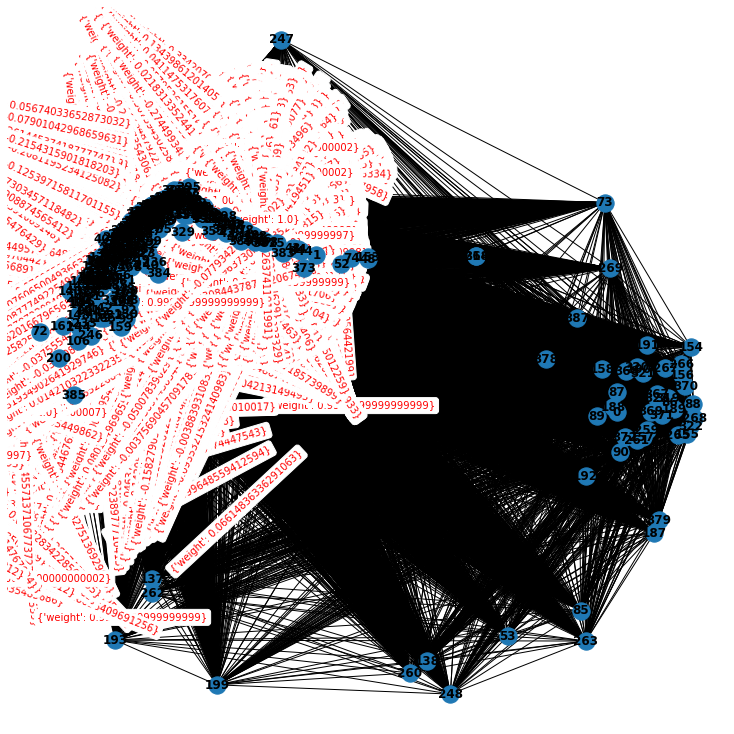

In [45]:
draw_graphs(sim_matrix)

In [46]:
scores = calculate_score(sim_matrix)
final = ranked_sentences(sentences, scores, n = 64)

PowerIterationFailedConvergence: ignored

In [47]:
sim_matrix

array([[ 1.        ,  0.60505425,  0.01237103, ...,  0.02216694,
         0.16167211, -0.02812072],
       [ 0.60505425,  1.        ,  0.76466081, ...,  0.23995562,
         0.27488049,  0.08307684],
       [ 0.01237103,  0.76466081,  1.        , ...,  0.33045949,
         0.25052112,  0.0982266 ],
       ...,
       [ 0.02216694,  0.23995562,  0.33045949, ...,  1.        ,
         0.33084438,  0.07542637],
       [ 0.16167211,  0.27488049,  0.25052112, ...,  0.33084438,
         1.        , -0.07793423],
       [-0.02812072,  0.08307684,  0.0982266 , ...,  0.07542637,
        -0.07793423,  1.        ]])

In [ ]:
final = flat_list(final)

In [ ]:
int_list = []
for note in final:
  int_list.append(note_to_int[note])
print(int_list)

[1974, 1267, 3, 1974, 1571, 1260, 1571, 1260, 867, 521, 1604, 1577, 933, 185, 1309, 1659, 4, 198]


## 결과 확인

In [ ]:
a = open('/content/idx2pos.pkl', 'rb')
voca = pickle.load(a)

real_sentence = ""
for int in int_list:

  try:
    int = int(int)
  except: pass

  if voca.get(int):
    if voca[int] == "UNK":
      break
    real_sentence += voca[int] + " "

print(real_sentence)

상한 눈물 의 상한 불사 자비 불사 자비 하면서 품 수만 잠기 가까이 피 무조건 줌 는 여기 
